In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
'''
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
'''

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

"\nfor dirname, _, filenames in os.walk('/kaggle/input'):\n    for filename in filenames:\n        print(os.path.join(dirname, filename))\n"

In [3]:
import os
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

import tensorflow as tf
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Rescaling,Input,Dense,Conv2D,MaxPool2D,Dropout,Flatten

2024-03-23 10:01:44.521236: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-23 10:01:44.521344: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-23 10:01:44.653234: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
data_path = "/kaggle/input/stanford-dogs-dataset/images/Images"

In [5]:
batch_size = 64
image_size = (256,256)

In [6]:
train_ds = image_dataset_from_directory(
    data_path,
    validation_split = 0.1,
    subset="training",
    seed = 42,
    image_size=image_size,
    batch_size=batch_size
)

Found 20580 files belonging to 120 classes.
Using 18522 files for training.


In [7]:
val_ds = image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset="validation",
    seed = 42,
    image_size = image_size,
    batch_size= batch_size
)

Found 20580 files belonging to 120 classes.
Using 4116 files for validation.


In [8]:
val_batches = tf.data.experimental.cardinality(val_ds)
test_ds = val_ds.take(val_batches//2)
val_ds = val_ds.skip(val_batches//2)

In [9]:
class_names = train_ds.class_names
class_names

['n02085620-Chihuahua',
 'n02085782-Japanese_spaniel',
 'n02085936-Maltese_dog',
 'n02086079-Pekinese',
 'n02086240-Shih-Tzu',
 'n02086646-Blenheim_spaniel',
 'n02086910-papillon',
 'n02087046-toy_terrier',
 'n02087394-Rhodesian_ridgeback',
 'n02088094-Afghan_hound',
 'n02088238-basset',
 'n02088364-beagle',
 'n02088466-bloodhound',
 'n02088632-bluetick',
 'n02089078-black-and-tan_coonhound',
 'n02089867-Walker_hound',
 'n02089973-English_foxhound',
 'n02090379-redbone',
 'n02090622-borzoi',
 'n02090721-Irish_wolfhound',
 'n02091032-Italian_greyhound',
 'n02091134-whippet',
 'n02091244-Ibizan_hound',
 'n02091467-Norwegian_elkhound',
 'n02091635-otterhound',
 'n02091831-Saluki',
 'n02092002-Scottish_deerhound',
 'n02092339-Weimaraner',
 'n02093256-Staffordshire_bullterrier',
 'n02093428-American_Staffordshire_terrier',
 'n02093647-Bedlington_terrier',
 'n02093754-Border_terrier',
 'n02093859-Kerry_blue_terrier',
 'n02093991-Irish_terrier',
 'n02094114-Norfolk_terrier',
 'n02094258-Norwi

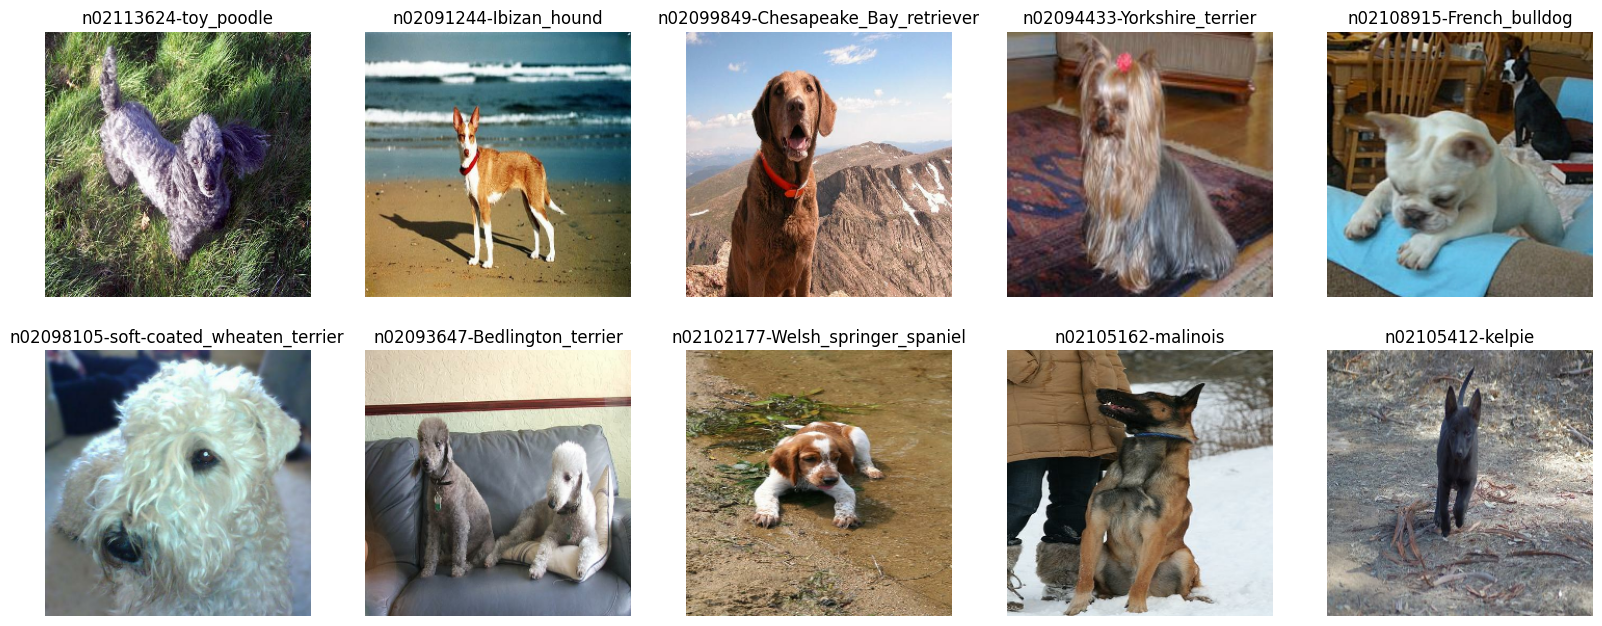

In [10]:
plt.figure(figsize=(20,20))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(5,5,i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [11]:
for image_batch,image_label in train_ds:
  print(image_batch.shape)
  print(image_label.shape)
  break

(64, 256, 256, 3)
(64,)


In [12]:
normalizing_images = tf.keras.layers.Rescaling(1/255.)
normalized_dataset_train = train_ds.map(lambda x,y: (normalizing_images(x),y))
normalized_dataset_val = val_ds.map(lambda x,y: (normalizing_images(x),y))
normalized_dataset_test = test_ds.map(lambda x,y: (normalizing_images(x),y))

In [13]:
images_batch,images_labels = next(iter(normalized_dataset_train))
first_image = image_batch[0]
print(np.min(first_image),np.max(first_image))

3.2326965 255.0


In [14]:
AUTOTUNE = tf.data.AUTOTUNE
normalized_dataset_train = normalized_dataset_train.prefetch(buffer_size=AUTOTUNE)
normalized_dataset_val = normalized_dataset_val.prefetch(buffer_size=AUTOTUNE)
normalized_dataset_test = normalized_dataset_test.prefetch(buffer_size=AUTOTUNE)

In [15]:
num_classes = len(class_names)
print(num_classes)

120


In [16]:
input = Input(shape=(256,256,3))
conv_layer1 = Conv2D(64,(3,3),activation="relu")(input)
max_pool_layer1 = MaxPool2D()(conv_layer1)
conv_layer2 = Conv2D(64,(3,3),activation="relu")(max_pool_layer1)
max_pool_layer2 = MaxPool2D()(conv_layer2)
conv_layer3 = Conv2D(64,(3,3),activation="relu")(max_pool_layer2)
max_pool_layer3 = MaxPool2D()(conv_layer3)
conv_layer4 = Conv2D(16,(3,3),activation="relu")(max_pool_layer3)
flatten = Flatten()(conv_layer4)
dense_1 = Dense(512,activation="relu")(flatten)
dense_2 = Dense(256,activation="relu")(dense_1)
dense_3 = Dense(128,activation="relu")(dense_2)
output = Dense(120,activation="softmax")(dense_3)

model = Model(inputs=input,outputs=output)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 254, 254, 64)   │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 127, 127, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 125, 125, 64)   │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 62, 62, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 60, 60, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 30, 30, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 16)     │         9,232 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 12544)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │     6,423,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 120)            │        15,480 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 6,687,624 (25.51 MB)

 Trainable params: 6,687,624 (25.51 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [19]:
#history = model.fit(normalized_dataset_train,
 #                   validation_data = normalized_dataset_val,
  #                  epochs=50)

In [20]:
base_model = tf.keras.applications.MobileNetV2(input_shape=(256,256,3),
                                              include_top = False,
                                              weights="imagenet")

/tmp/ipykernel_34/4066648621.py:1: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = tf.keras.applications.MobileNetV2(input_shape=(256,256,3),


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [21]:
image_batch,image_label = next(iter(normalized_dataset_train))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(64, 8, 8, 1280)


In [22]:
base_model.trainable=False

In [23]:
base_model.summary()

Model: "mobilenetv2_1.00_224"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 256,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1 (Conv2D)      │ (None, 128, 128,  │        864 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bn_Conv1            │ (None, 128, 128,  │        128 │ Conv1[0][0]       │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ Conv1_relu (ReLU)   │ (None, 128, 128,  │          0 │ bn_Conv1[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        288 │ Conv1_relu[0][0]  │
│ (DepthwiseConv2D)   │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │        128 │ expanded_conv_de… │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_dept… │ (None, 128, 128,  │          0 │ expanded_conv_de… │
│ (ReLU)              │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │        512 │ expanded_conv_de… │
│ (Conv2D)            │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ expanded_conv_proj… │ (None, 128, 128,  │         64 │ expanded_conv_pr… │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand      │ (None, 128, 128,  │      1,536 │ expanded_conv_pr… │
│ (Conv2D)            │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_BN   │ (None, 128, 128,  │        384 │ block_1_expand[0… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_expand_relu │ (None, 128, 128,  │          0 │ block_1_expand_B… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_pad         │ (None, 129, 129,  │          0 │ block_1_expand_r… │
│ (ZeroPadding2D)     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise   │ (None, 64, 64,    │        864 │ block_1_pad[0][0] │
│ (DepthwiseConv2D)   │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │        384 │ block_1_depthwis… │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_depthwise_… │ (None, 64, 64,    │          0 │ block_1_depthwis… │
│ (ReLU)              │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block_1_project     │ (None, 64, 64,    │      2,304 │ block_1_depthwis

 Total params: 2,257,984 (8.61 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 2,257,984 (8.61 MB)

In [24]:
global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(64, 1280)


In [25]:
prediction_layer = tf.keras.layers.Dense(120,activation="softmax")
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(64, 120)


In [26]:
inputs = Input(shape=(256,256,3))
x = base_model(inputs)
x = global_average_layer(x)
x = Dropout(0.2)(x)
outputs = prediction_layer(x)

model = Model(inputs,outputs)

In [27]:
model.summary()

Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 256, 256, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 8, 8, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 120)            │       153,720 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,411,704 (9.20 MB)

 Trainable params: 153,720 (600.47 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

In [28]:
len(model.trainable_variables)

2

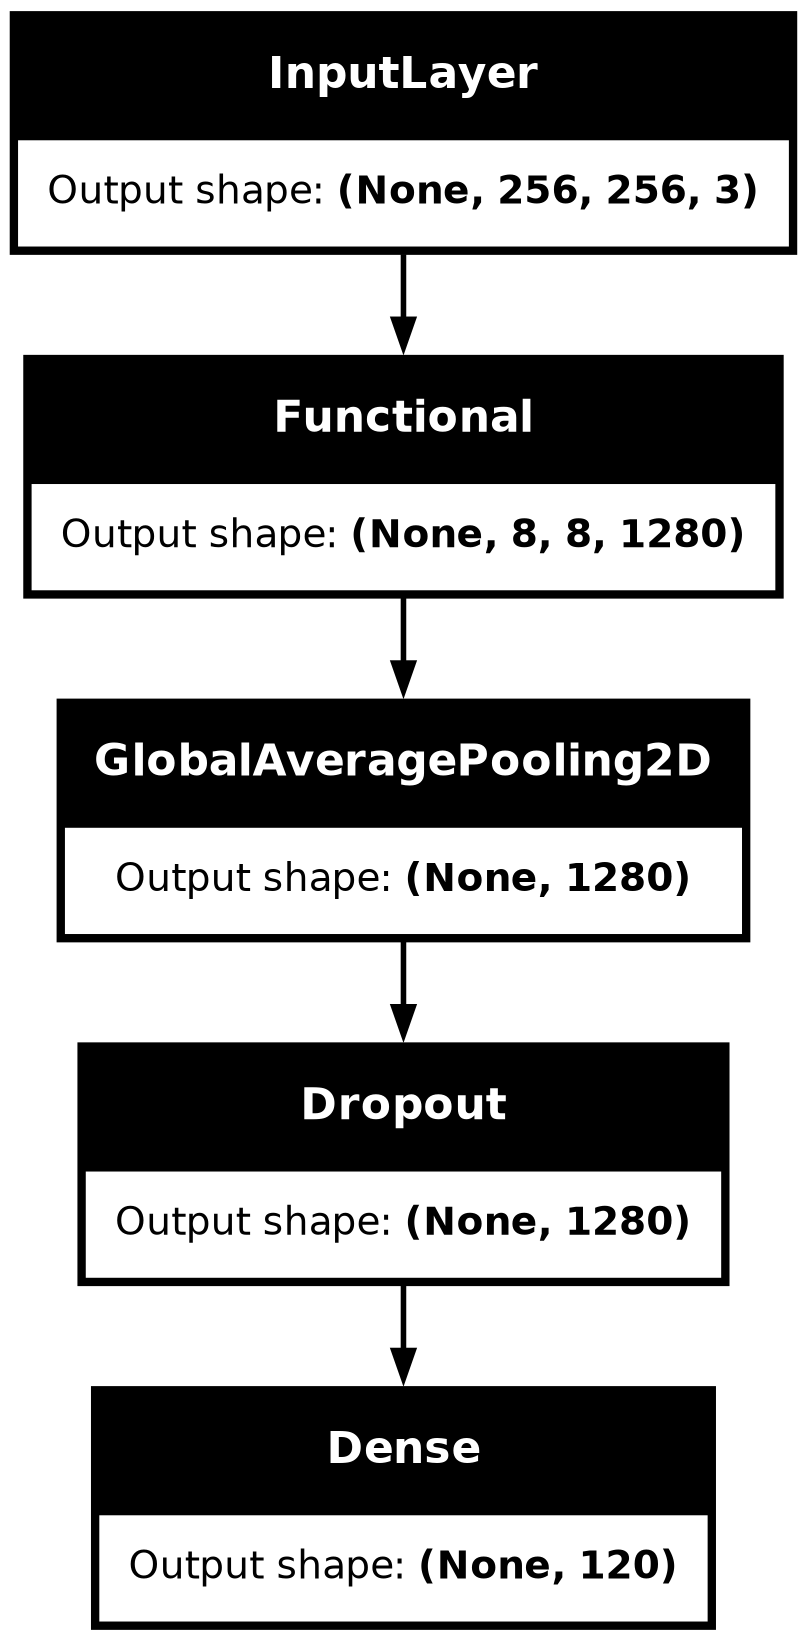

In [29]:
tf.keras.utils.plot_model(model,show_shapes=True)

In [30]:
model.compile(optimizer="adam",loss="sparse_categorical_crossentropy",metrics=["accuracy"])

In [31]:
history = model.fit(normalized_dataset_train,
                    validation_data=normalized_dataset_val,
                   epochs=15)

Epoch 1/15
  3/290 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.0095 - loss: 5.1431 

I0000 00:00:1711188148.500254      91 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


290/290 ━━━━━━━━━━━━━━━━━━━━ 77s 211ms/step - accuracy: 0.4598 - loss: 2.5088 - val_accuracy: 0.8061 - val_loss: 0.7141
Epoch 2/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 31s 104ms/step - accuracy: 0.8292 - loss: 0.6065 - val_accuracy: 0.8254 - val_loss: 0.5835
Epoch 3/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 32s 107ms/step - accuracy: 0.8658 - loss: 0.4551 - val_accuracy: 0.8390 - val_loss: 0.5360
Epoch 4/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.8921 - loss: 0.3679 - val_accuracy: 0.8438 - val_loss: 0.5247
Epoch 5/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 94ms/step - accuracy: 0.9140 - loss: 0.3023 - val_accuracy: 0.8385 - val_loss: 0.5243
Epoch 6/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 30s 101ms/step - accuracy: 0.9291 - loss: 0.2557 - val_accuracy: 0.8385 - val_loss: 0.5203
Epoch 7/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 31s 106ms/step - accuracy: 0.9405 - loss: 0.2243 - val_accuracy: 0.8404 - val_loss: 0.5104
Epoch 8/15
290/290 ━━━━━━━━━━━━━━━━━━━━ 28s 93ms/step - accuracy: 0.9485 - loss: 0.1958 - val_ac

In [32]:
loss,accuracy = model.evaluate(normalized_dataset_test)

32/32 ━━━━━━━━━━━━━━━━━━━━ 3s 88ms/step - accuracy: 0.9966 - loss: 0.0535


In [33]:
loss,accuracy

(0.08326558023691177, 0.9853515625)

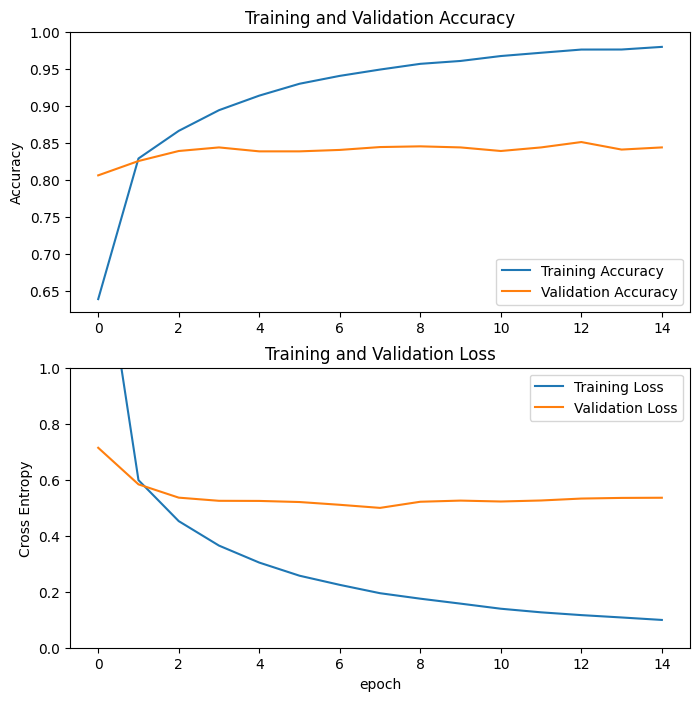

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [35]:
images_test,labels_test = next(iter(normalized_dataset_test))

In [36]:
images_test[0].shape

TensorShape([256, 256, 3])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step
Predicted_label = n02105056-groenendael and Actual Label = n02105056-groenendael


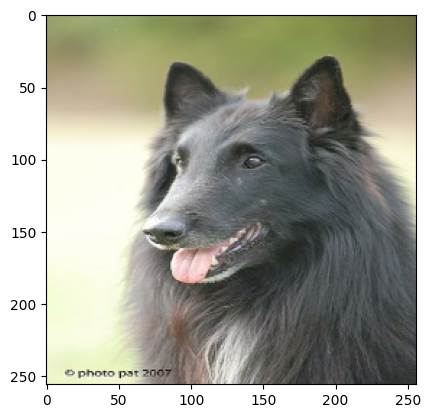

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02095570-Lakeland_terrier and Actual Label = n02095570-Lakeland_terrier


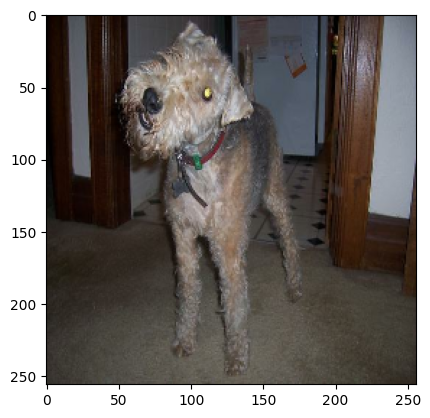

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02107142-Doberman and Actual Label = n02107142-Doberman


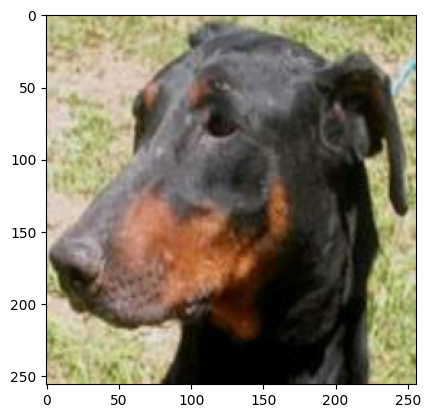

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted_label = n02088364-beagle and Actual Label = n02088364-beagle


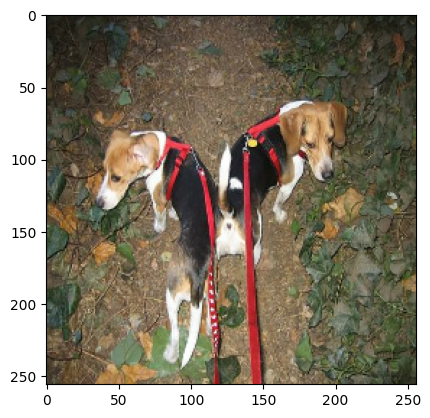

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted_label = n02109047-Great_Dane and Actual Label = n02109047-Great_Dane


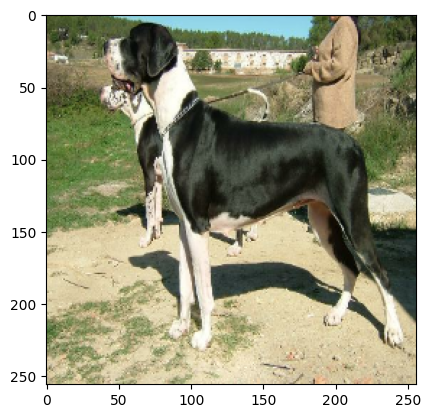

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02086910-papillon and Actual Label = n02086910-papillon


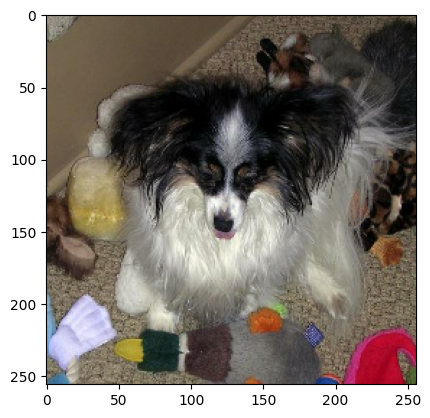

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted_label = n02091244-Ibizan_hound and Actual Label = n02091244-Ibizan_hound


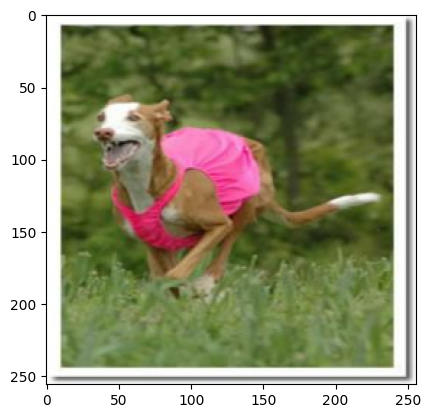

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02099849-Chesapeake_Bay_retriever and Actual Label = n02099849-Chesapeake_Bay_retriever


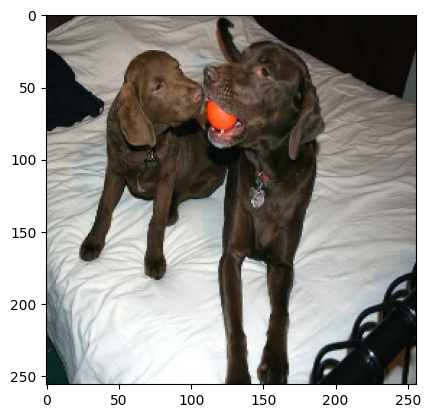

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step
Predicted_label = n02091467-Norwegian_elkhound and Actual Label = n02091467-Norwegian_elkhound


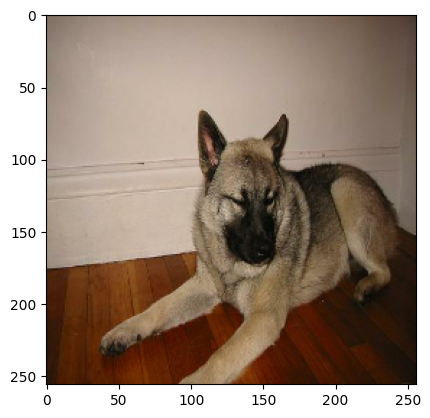

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02113978-Mexican_hairless and Actual Label = n02113978-Mexican_hairless


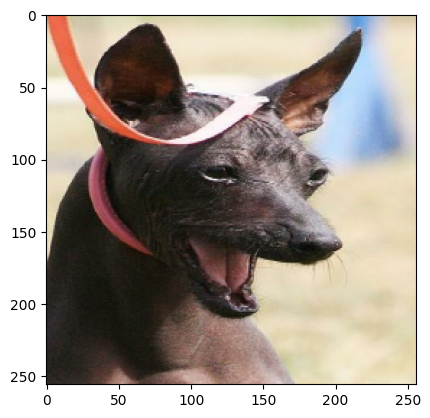

In [38]:
for i in range(10):
    plt.imshow(images_test[i])
    prediction = np.argmax(model.predict(images_test[i][np.newaxis,...]))
    print(f"Predicted_label = {class_names[prediction]} and Actual Label = {class_names[labels_test[i]]}")
    plt.show()

In [39]:
testing_own_images_path = "/kaggle/input/just-a-photo/"

In [40]:
def preprocessing_for_testing(image_path):
    image_1 = Image.open(image_path)
    image_1 = image_1.resize((256,256))
    image_1_array = np.array(image_1)
    image_1_array = image_1_array/255.0
    
    return image_1_array

In [41]:
images_for_test = os.listdir(testing_own_images_path)

0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02113978-Mexican_hairless


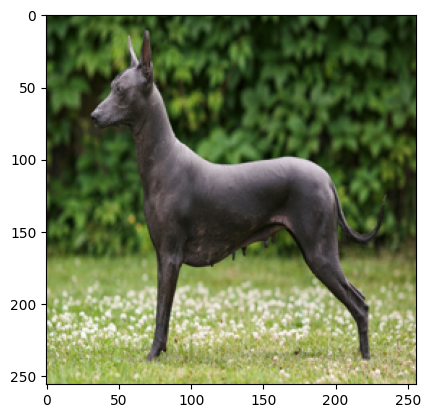

1
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted_label = n02085620-Chihuahua


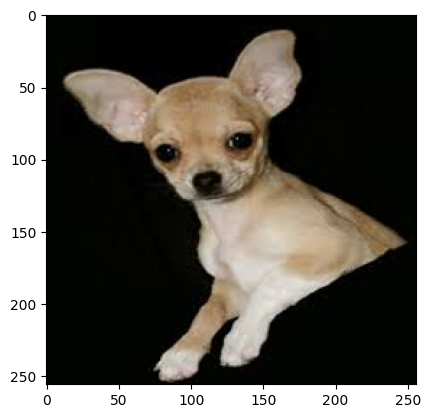

2
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02109047-Great_Dane


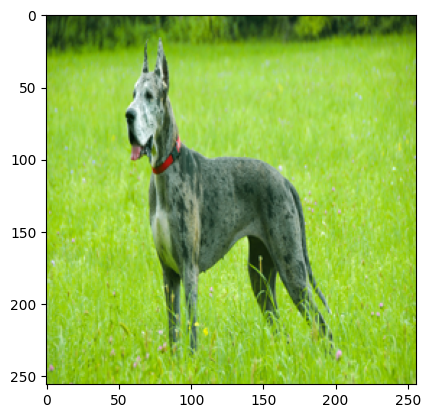

3
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
Predicted_label = n02110958-pug


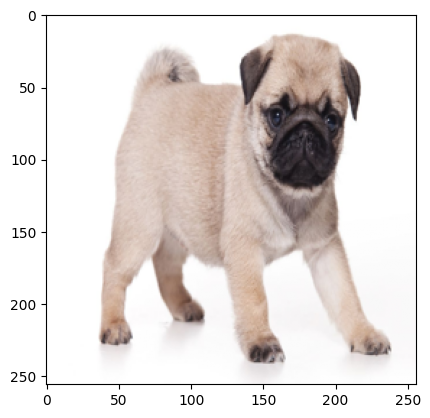

In [42]:
from PIL import Image
for i in range(len(os.listdir(testing_own_images_path))):
    image_array = preprocessing_for_testing(os.path.join(testing_own_images_path,images_for_test[i]))
    print(i)
    plt.imshow(image_array)
    prediction = np.argmax(model.predict(image_array[np.newaxis,...]))
    print(f"Predicted_label = {class_names[prediction]}")
    plt.show()
    plt.close()

In [54]:
model.save("dog_model.keras")

In [55]:
from IPython.display import FileLink
FileLink(r"dog_model.keras")

/kaggle/working/dog_model.keras